# Time series Forecasting in Python & R
> Time series forecasting using various forecasting methods in Python & R in one notebook. I will try to build the intuition behind different methods, explain the key concepts as I build the models and explain how properties of the time series found in EDA affect the model choice/parameters and accuracy. Best model will later be deployed in Azure and consumed in Power BI. 

- toc: true- branch: master- badges: true
- comments: true
- author: Sandeep Pawar
- categories: [forecasting, Python, R, statsmodels]

### Project Goals

This is a quarterly sales data of a French retail company from Prof. Rob Hyndman's ["Forecasting Methods & Applications"](https://robjhyndman.com/forecasting/) book. I have uploaded the data to my [github](https://github.com/pawarbi/blog/tree/master/data). I chose this example because it's deceptively simple, easy to explain/demonstrate key concepts and Prof. Hyndman later applied the [state space approach](https://robjhyndman.com/expsmooth/) to this series using family of ETS models. The goals for this project are:

1. Forecast 1 year ahead , i.e next 4 quarters 
2. Create a forecast pipeline using Python first & later R for comparison purposes
3. Compare various forecasting methods & choose the best model. Evaluate the models using various evaluation criteria.
4. Focus on explanability and identify how EDA informs the model selection 
5. Dcoument my findings & notes to self

### Importing libraries


In [76]:
#Author: Sandeep Pawar
#Version: 1.0
#Date Mar 27, 2020

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import anderson
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung
#from nimbusml.timeseries import SsaForecaster
from statsmodels.tsa.statespace.tools import diff as diff
import statsmodels.api as sm
import altair as alt



import itertools

#import gluonts


import pmdarima as pm
from pmdarima import ARIMA, auto_arima

from scipy import signal
from scipy.stats import shapiro
from scipy.stats import boxcox


%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import rpy2
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython



The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython



*I have found that results could be significanlty different if you use different version of the libraries, especially with 
statsmodels & rpy2. So if you want to reproduce these results, be sure to use the same versions of these libraries. For this project, I created a conda virtual environment as rpy2 requires specific versions of Pandas & certain R libraries*  


In [2]:
#Printing library versions

print('Pandas:', pd.__version__)
print('Statsmodels:', sm.__version__)
print('Scipy:', scipy.__version__)
print('Rpy2:', rpy2.__version__)

Pandas: 0.25.0
Statsmodels: 0.11.0
Scipy: 1.4.1
Rpy2: 2.9.4


In [3]:
# Define some custom functions to help the analysis


def MAPE(y_true, y_pred): 
    """
    %Error compares true value with predicted value. Lower the better. Use this along with rmse(). If the series has 
    outliers, compare/select model using MAPE instead of rmse()
    
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def residcheck(residuals, lags):
    """
    Function to check if the residuals are white noise. Ideally the residuals should be uncorrelated, zero mean, 
    constant variance and normally distributed. First two are must, while last two are good to have. 
    If the first two are not met, we have not fully captured the information from the data for prediction. 
    Consider different model and/or add exogenous variable. 
    
    If Ljung Box test shows p> 0.05, the residuals as a group are white noise. Some lags might still be significant. 
    
    Lags should be min(2*seasonal_period, T/5)
    
    from scipy.stats import anderson
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html
    anderson().statistic <0.05 => Normal distribution
    
    plots from: https://tomaugspurger.github.io/modern-7-timeseries.html
    
    """
    resid_mean = np.mean(residuals)
    lj_p_val = min(ljung(x=residuals, lags=lags)[1])
    norm_p_val =  anderson(residuals, dist='norm').statistic
    adfuller_p = adfuller(residuals)[1]
    
    
    
    fig = plt.figure(figsize=(10,8))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2);
    acf_ax = plt.subplot2grid(layout, (1, 0));
    kde_ax = plt.subplot2grid(layout, (1, 1));

    residuals.plot(ax=ts_ax)
    plot_acf(residuals, lags=lags, ax=acf_ax);
    sns.kdeplot(residuals);
    #[ax.set_xlim(1.5) for ax in [acf_ax, kde_ax]]
    sns.despine()
    plt.tight_layout();
    
    print("** Mean of the residuals: ", resid_mean)
    
    print("\n** Ljung Box Test, p-value:", lj_p_val, "(>0.05, Uncorrelated)" if (lj_p_val > 0.05) else "(<0.05, Correlated)")
    
    print("\n** A-D Normality Test, p_value:", norm_p_val, "(<0.05, Normal)" if (norm_p_val<0.05) else "(>0.05, Not-normal)")
    
    print("\n** AD Fuller, p_value:", adfuller_p, "(>0.05, Non-stationary)" if (adfuller_p > 0.05) else "(<0.05, Stationary)")
    
    
    
    return ts_ax, acf_ax, kde_ax
    
def accuracy(y1,y2):
    
    accuracy_df=pd.DataFrame()
    
    rms_error = np.round(rmse(y1, y2),1)
    
    map_error = np.round(np.mean(np.abs((np.array(y1) - np.array(y2)) / np.array(y1))) * 100,1)
           
    accuracy_df=accuracy_df.append({"RMSE":rms_error, "%MAPE": map_error}, ignore_index=True)
    
    return accuracy_df
    
    
    



### Importing Data

In [60]:

path = 'https://github.com/pawarbi/blog/blob/master/data/ts_frenchretail.xlsx?raw=true'

#Sales numbers are in thousands, so I am dividing by 1000 to make it easier to work with numbers, especially squared errors
data = pd.read_excel(path, parse_dates=True, index_col="Date").div(1000)

data.index.freq='Q'

data.head()       


,Sales
Date,
2012-03-31,362.0
2012-06-30,385.0
2012-09-30,432.0
2012-12-31,341.0
2013-03-31,382.0


I have explicitly set the index frequency to *quarterly*. This makes with plotting and analyzing data with pandas plotting easier. More date offsets can be found in Pandas [documentation here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html). freq='Q-DEC' below shows quarterly data ending in December. Other advantage of setting the 'freq' value is that if the dates are not continous, Pandas will throw an error, which can be used to fix the data quality error and make the series continuos. Other common date offsets are:
 - Monthly Start: 'MS'
 - Quarterly Start: 'QS'
 - Weekly: 'W'
 - Bi Weekly: '2W'
 - Business/ Weekday: 'B
 - Hourly: 'H'
 

In [10]:
data.index

DatetimeIndex(['2012-03-31', '2012-06-30', '2012-09-30', '2012-12-31',
               '2013-03-31', '2013-06-30', '2013-09-30', '2013-12-31',
               '2014-03-31', '2014-06-30', '2014-09-30', '2014-12-31',
               '2015-03-31', '2015-06-30', '2015-09-30', '2015-12-31',
               '2016-03-31', '2016-06-30', '2016-09-30', '2016-12-31',
               '2017-03-31', '2017-06-30', '2017-09-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', freq='Q-DEC')

## Train Test Split:

Before analyzing the data, first split it into train and test(hold-out) for model evaluation. All the EDA and model fitting/selection should be done first using train data. DON'T look at test sample until later to avoid any bias. In this case we want to forecast 4 quarters into the future so test size should be at least 4 or more. I will use last 6 samples as hold-out. Note that in this case I am always selecting the last 6 values for test by using .iloc[:-6]. As we get more data, this will ensure that last 6 values are always for validation. Unlike typical train/test split, we can not shuffle the data before splitting. 

#### Cross-validation:
Data  can be split using above method or using cross-validation where the series is split into number of successive segments and model is tested using one-step ahead forecast.Model accuracy in that case is based on mean of the cross-validation errors over the number of splits used. This minimizes chances of overfitting. Be sure include at least 1-2 seasonal periods to capture the seasonality. e.g. in this case, the first training set of the CV should be min 8 values so the model has captured seasonal behaviour from 2 years. This is the preferred method when the time series is short. 

In this example, the series has 24 obervations so I can use last 6-8 for validation. When this method is used, always check the sensisitivity of the model performance and model parameters to train/test size. If AIC or AICc is used for model evaluation, it approximatley approaches cross-validation error asymptotically.  


<font color='red'>Insert picture here of train/test split</font>

In [61]:
train = data.iloc[:-6]
test  = data.iloc[-6:]
#forecast horizon
h = 6
train_length = len(train)

print('train_length:',train_length, '\n test_length:', len(test) )



train_length: 18 
 test_length: 6


## Exploratory Data Analysis & Modeling Implications

These are some of the questions I ask at various stages of model building. 


1. **Are there any null values? how many? best way to impute the null data?**
    - If null/NaNs are present, first identify why the data is missing and if NaNs mean anything. Missing values can be 
      filled by interpolation, forward-fill or backward-fill depending on the data nd context. Also make sure null  
      doesnt mean 0, which is acceptable but has modeling implications. 
      
      
2. **Are the data/dates continuous?**
    - In this exmaple I am only looking at continous time-series. There other methods that deal with non-continuous data. ETS & ARIMA require the data to be continuous. 
    
    
3. **Are there any duplicate dates, data?**
    - Remove the duplicates or aggregate the data (e.g. average or mean) to treat duplicates
    
    
4. **Any 'potential' outliers?**
    - Outliers are defined as observations that differ significantly from the general observations. Identify if the data is 
      susceptible to outliers/spikes, if outliers mean anything and how to define outliers. While 'Outlier Detection' is a  
      topic in itself, in forecasting context we want to treat outliers before the data is used for fitting the model. Both 
      ETS and ARIMA class of models (especially ARIMA) are not robust to outliers and can provide erroneous forecasts. Data       should be analyzed while keeping seasonality in mind. e.g. a sudden spike could be because of the seasonal behaviour.
      
    - Few ways to treat outliers:
        - Use Box and whiskers and clip the values tha exceed 1 & 99th percentile 
        - Use residual standard deviation and compare against observed values
        - Use moving average to check spikes/troughs
    
    - Another important reason to pay close attention to outliers is that we will choose the appropriate error metric based 
      on that. There are many error metrics used to assess accuracy of forecasts, viz. MAE, MSE, RMSE, %MAPE, %sMAPE. If 
      outliers are present, don't use RMSE because the squaring the error at the outlier value can inflate the RMSE. In that 
      case model should be selected/assessed using %MAPE or %sMAPE. More on that later. 
      
      
5. **Visually any trend, seasonality, cyclic behaviour?** 
     - This will help us choose the appropriate model (Single, Double, Triple Exponential Smoothing, ARIMA/SARIMA)
     - If cyclic behiour is present (seasonality is short-order variation e.g. month/quarter, cyclicity occurs over 10-20 
       years e.g. recession) we will need to use different type of ETS model (X11, STL). Depending on the context and 
       purpose of analysis, seasoanlity adjustment may also be needed.
     - If multiple seasonalities are present, ETS or ARIMA cannot be used. SSA, TBATS, harmonic regression are more 
       appropriate in that case.
     - Frequency of seasonality is importnat. ETS & SARIMAX are nor appropriate for high frequency data such as hourly, daily, sub-daily and even weekly. Consider using SSA,TBTAS, FB Prophet, deep learning models.
     
       
6. **How does the data change from season to season for each year?**
     - Does it increas/decrease with the trend? Changes slowly, rapidly or remains constant. This is an important 
       observation to be made, especially for ETS model, as it can determine the parametrs to be used & if any preprocessing 
       will be needed.
      
       

7. **How does the data change from year to year?**
     - 



8. **Distribution of the data? will we need any transformations?**
      - While normally distributed data is not a requirement for forecasting and doesnt necessarily improve point forecast accuracy, it can help stablize the variance and narrow the prediction interval. 
      - Plot the histogram/KDE for each time period (e.g. each year and each seasona) to get gauge peakedness, spread in the data. It can also help compare different periods and track trends over time.
      - If the data is severely skewed, consider normalizing the data before training the model. Be sure to apply inverse transformation on the forecasts. Use the same transformation parameters on the train and test sets. Stabilizing the variance by using Box Cox transformation (special case being log & inverse transform), power law etc can help more than normalizing the data.  
      - Watch out for outliers before transformation as it will affect the transformation
      - Plottng distribution also helps track "concept-drift" in the data, *i.e.* does the underlying temporal structure / assumption change over time. If the drift is significant, refit the model or at least re-evaluate. This can be tricky in time series analysis.
      - Uncertainty in the training data will lead to higher uncertainty in the forecast. If the data is highly volatile/uncertain (seen by spread in the distribution, standard deviation, non-constant variance etc), ETS and ARIMA models will not be suitable. Consider GARCH and other methods.
      
      
9. **Is the data stationary? Is this a white noise, random walk process?** 

      - Perhaps the most important concept to keep in mind when doing time series analysis and forecasting is that, time series is a *probabilistic / stochastic process*, and the time series we are analyzing is a *'realization of a stochastic process'*. A time signal could be deterministic or stochastic/probabilistic. In a deterministic process, the future values can be predicted exactly with a mathematical function e.g. y = sin(2$\pi$ft). In our case, the future values can only be expressed in terms of probability distribution. The point estimates are mean/median of the distribution. By definition, the mean has a distribution around it and as such the stakeholders should be made aware of the probabilistic nature of the forecast through uncertainty estimates.       
            
      - ***Stationarity***: Statistical stationarity means the time series has constant mean, variance and autocorrelation is insignificant at all lags. Autocorrelation is a mouthful, all it means is the correlation with its past self. e.g. to check if two variables are linearly correlated with each other, we calculate their coeff of correlation (Pearson correlation). Similarly,  *autocorrelation* does the same thing but with its past values (i.e lags). More on that later. For a stationary time series, the properties are the same no matter which part of the series (w.r.t time) we look at. This is a core concept of the ARIMA methods, as only sttaionary processes can be modeled using ARIMA. ETS can handle non-stationary processes. 
      - ***White Noise***: If a time series has zero mean and a constant variance $\sigma^2$, it's a white noise. The variables in this case are *independent and identically distributed* (i.i.d) and are uncorrelated. We want the residuals left after fitting the model to be a white noise. White noise can be identified by using ADFuller test and plotting autocorrelation function (ACF) plots. 
      - ***Random Walk***: Random walks are non-stationary. It's mean or variance or both changes over time. Random walk cannot be forecast because we have more unknowns than the data so we will end up having way to many parameters in the model. In essence, random walk has no pattern to it, it's last data point plus some random signal (drift). Thus, if the first difference of the time series results in a white noise, it's an indication of a Random Walk. Most equity stocks are random walk but by looking at percent difference (%growth over time) we can study the white noise.
       
       
                                   Next data point = Last Data point + Random Noise 
                       =>    Next Data Point - Last Data Point = Random Noise (i.e White noise) 
                    
      -  
      
      
10. Auto-correlation? at what lag? 
11. If trend is present, momentum or mean-reversing? 
12. Break-points in the series?
13. Intermittent demand?


In [6]:
#Any missing data?
print("missing_data:", train.isna().sum())
print("unique dates:", train.index.nunique())

missing_data: Sales    0
dtype: int64
unique dates: 18


In [ ]:
pd.date_range()

In [7]:
pd.crosstab(index=train.index.year, columns=train.index.quarter)

col_0,1,2,3,4
row_0,,,,
2012,1,1,1,1
2013,1,1,1,1
2014,1,1,1,1
2015,1,1,1,1
2016,1,1,0,0


Observations:
1. No null values
2. Length of the train set is 12 and we have 12 unique dates/quarters so no duplicate dates
3. Each year and quarter has 1 observation, so no duplicates and data is continuous

In [114]:
train_chart=alt.Chart(train.reset_index()).mark_line(point=True).encode(
    x='Date', 
    y='Sales', 
    tooltip=['Date', 'Sales'])

rolling_mean = alt.Chart(train.reset_index()).mark_trail(
    color='orange',
    size=1
).transform_window(
    rolling_mean='mean(Sales)',
    frame=[-4,4]
).encode(
    x='Date:T',
    y='rolling_mean:Q',
    size='Sales'
)

(train_chart + rolling_mean).properties(width=800)

alt.LayerChart(...)

green : #4daa4e 77 170 78

red: #d6555c rgb(214, 85, 92)

orange: #ff8c0f rgb(255, 161, 40)

blue: #4d6eae rgb(77, 110, 174)


In [91]:
alt.Chart(train.reset_index()).mark_line(point=True).encode(
    x='quarter(Date)', 
    y='Sales',
    column='year(Date)',
    tooltip=['Date', 'Sales']).properties(
    width=100)

alt.Chart(...)

In [89]:
alt.Chart(train.reset_index()).mark_line(point=True).encode(
    x='year(Date)', 
    y='Sales',
    column='quarter(Date)',
    tooltip=['Date', 'Sales']).properties(
    width=100)

alt.Chart(...)

Observations:
1. Sales goes up from Q1 to Q3, peaks in Q3, drops in Q4. Definitely a seasoanl pattern. => Model should capture seasonality
2. Just comparing Q4 peaks, sales has gone up from \\$432K to \\$582K => Trend exists, Model should capture trend. No cyclic behaviour 
3. Overall data looks clean and 'visually' no outliers or anamolies => won't need any data cleaning or filtering

### Quarterly / Yearly trends & distrbution

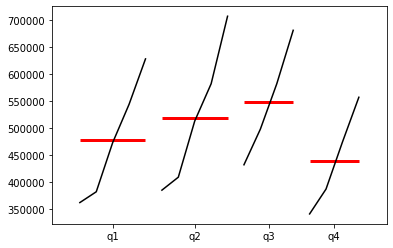

In [9]:
#Quarterly plot: Shows trend for Q1-Q4 for each of the years. Red line shows mean
quarter_plot(train);

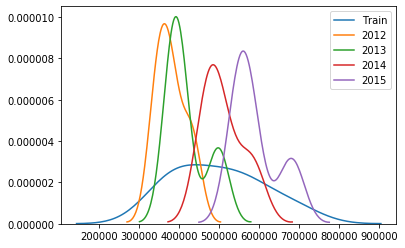

In [12]:
sns.distplot(train,         label='Train', hist=False)
sns.distplot(train['2012'], label='2012', hist=False)
sns.distplot(train['2013'], label='2013', hist=False)
sns.distplot(train['2014'], label='2014', hist=False)
sns.distplot(train['2015'], label='2015', hist=False);



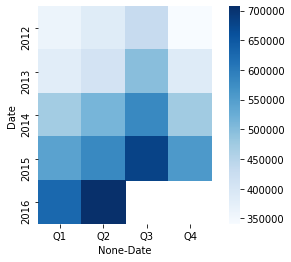

In [10]:
sns.heatmap(pd.pivot_table(data=train, index=train.index.year, columns=train.index.quarter),
           square=True,
           cmap='Blues',
           xticklabels=["Q1", "Q2", "Q3", "Q4"])

Observations:
1. Quarter plot & heatmap confirms peak in Q3, drop in Q4. 
2. For each of the years the upward trend observed in all quarters
3. Kenel Density plot shows somewhat normal distribution, (bi-modal). Peaks shifts from 2012 to 2014 indicating increase in mean. Overall distribution profile is consistent across the years. => mean centering/scaling likely not needed

### 2nd order properties of the time series

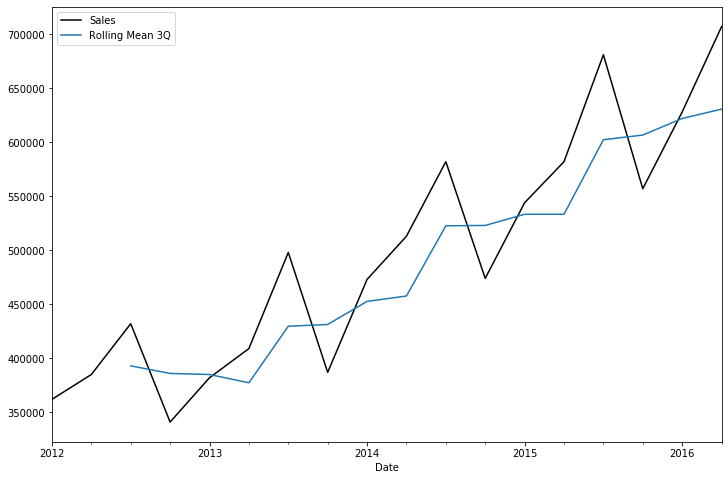

In [11]:
#Is the data stationary? 

train.plot(figsize=(12,8), legend=True, label="Train", cmap='gray')
train["Sales"].rolling(3).mean().plot(legend=True, label="Rolling Mean 3Q");

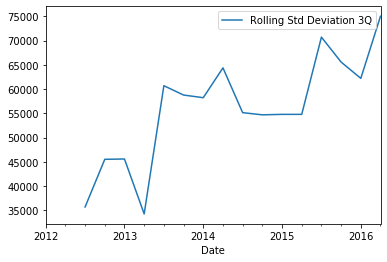

In [12]:
train["Sales"].rolling(3).std().plot(legend=True, label="Rolling Std Deviation 3Q");

Visually mean and std dev change over time => Not stationary. 

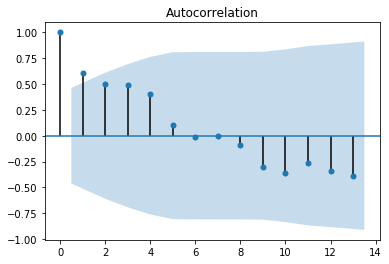

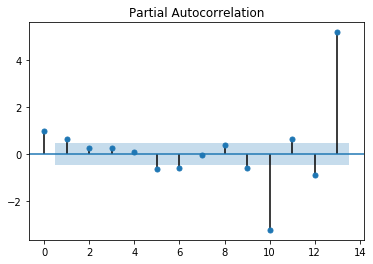

In [13]:
plot_acf(train);
plot_pacf(train);

Observations:
1. ACF: Very interesting. auto-correlation plot shows autocorrelation coeff is insignificant at all lag values (within the blue 95%CI band). Note that coeff sign changed after 4 lags indicating seasonal pattern with seasonal_period=4 (which we already knew since tihs is a quarterly data). Also, alternating pattern shows mean-reversion process. since AC coeff is not significant likley MA(q=0) process
2. PACF: At lag 1, barely within the 95% CI but significant at lags 5,6,7,8,9,10,11, 12. Significant peak at 8 which is harmonic of 4. Alternating pattern shows seasonal behaviour. Significant peaks show AR process. Differencing would be needed to make the data stationary. => For ARIMA model ~ ARIMA(1,1,0)??

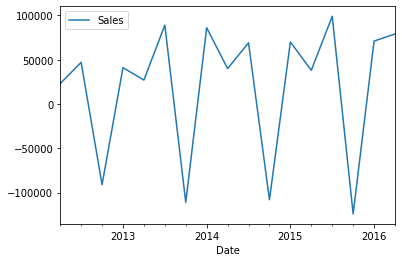

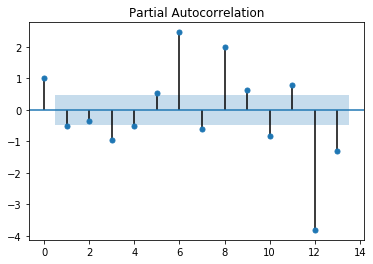

In [14]:
#Let's try differencing d=1 to de-trend the series
de_trended = train.diff(1).dropna()
de_trended.plot(label="De-trended", legend=True)
plot_pacf(de_trended);


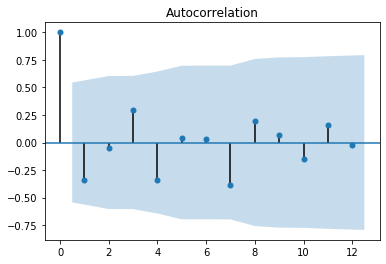

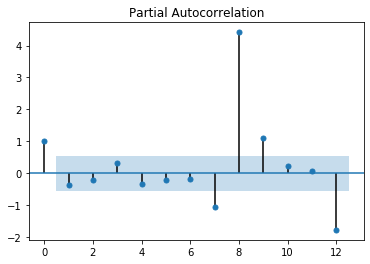

In [18]:
plot_acf(diff(train, 1,1,4));
plot_pacf(diff(train, 1,1,4));

Differencing didnot help stationarize the series ! 

In [15]:
#Statistical test for stationarity
adfuller(train["Sales"])

(2.452618859692341,
 0.9990329594016152,
 7,
 10,
 {'1%': -4.331573, '5%': -3.23295, '10%': -2.7487},
 212.6280742064206)

p = 0.99 which is >0.05. **Time series is not stationary**

In [170]:
#Shapiri-Wilcox test for normality. if p< 0.05, data is normal
sm.stats.diagnostic.kstest_normal(train["Sales"],"norm")[1]

0.7165057864636755

Series is not normally distributed

De-trended series, ACF/PACF plots show seasonality=4 since this is a quarterly data. I am going to try Power Spectrum analysis to see if there are any other frequencies/signals

Summary: What do I know so far?
1. Trend & seasonality present. My guess trend=additive, seasonal ="add/mul", seasonal_periods=4, no damping, since differencing didnot help, highly non-stationary, ETS residual may be non-normal
2. Normally distributed, boxcox, log, scaling transofmration likley not needed
3. No outliers to treat
4. Likley AR process with high order differencing for SARIMA

In [16]:
anderson(train["Sales"]).statistic

0.29859509940060747

# ETS Model


#Decompose the series into trend, season and resid. Goals:
1. Is the trend linear, linear exponential, damped
2. Seasonality?
3. Are the residuals normal? If the residuals are not normal, point-forecasts will still be accurate but the prediction intervals wont be. Bootstrapping maybe needed

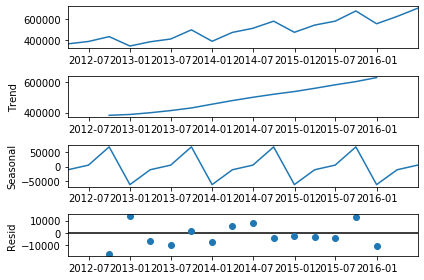

In [33]:
decompose = seasonal_decompose(train)
decompose.plot();

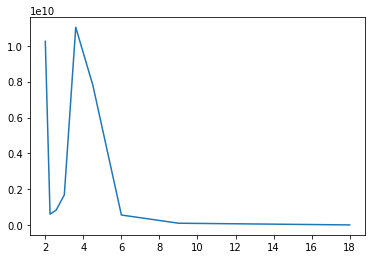

In [52]:
f, fx = signal.periodogram(decompose.seasonal.values)

freq=f.reshape(len(f),1) #reshape the array to a column
amplitude = fx.reshape(len(f),1)
plt.plot(1/freq, amplitude  );


Power Spectral analysis shows a peak at 4 => seasonality =4

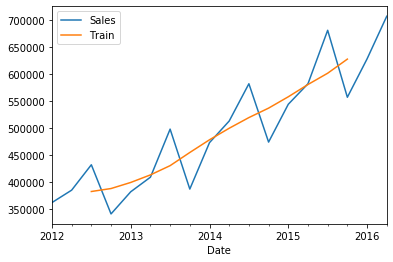

<Figure size 864x648 with 0 Axes>

In [24]:
fig, ax = plt.subplots(sharex=True, sharey=True)
train.plot(legend=True, label="Train", sharex=True, ax=ax)
decompose.trend.plot(legend=True, label="Train",ax=ax)
plt.figure(figsize=(12,9))
plt.show()

Trend does look exponential. Do we need boxcox? may be not but worth trying.

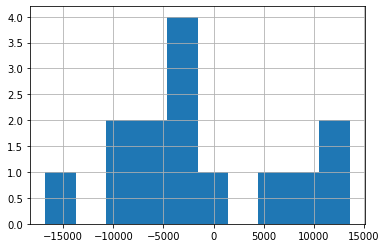

In [25]:
#Distribution of the residual. Not normal. be sure to run diagnostics on the fitted model's residuals 
decompose.resid.hist();

## Grid-searching ETS model 

Grid Searching the parameter space

In [27]:
model_ses = SimpleExpSmoothing(train["Sales"]).fit()
model1=ExponentialSmoothing(train["Sales"], trend="add", damped=False, seasonal="add", seasonal_periods=4).fit()
model2=ExponentialSmoothing(train["Sales"], trend="add", damped=False, seasonal="mul", seasonal_periods=4).fit()
model3=ExponentialSmoothing(train["Sales"], trend="mul", damped=False, seasonal="add", seasonal_periods=4).fit()
model4=ExponentialSmoothing(train["Sales"], trend="mul", damped=False, seasonal="mul", seasonal_periods=4).fit()
model5=ExponentialSmoothing(train["Sales"], trend="add", damped=False, seasonal="add", seasonal_periods=4).fit(use_boxcox=True)
model6=ExponentialSmoothing(train["Sales"], trend="add", damped=False, seasonal="mul", seasonal_periods=4).fit(use_boxcox=True)
print("Train    RMSE,                       MAPE:",
      "\n SES:   ", rmse(train["Sales"],model_ses.fittedvalues)," , ",   MAPE(train["Sales"],model_ses.fittedvalues), 
      "\n model1:", rmse(train["Sales"],model1.fittedvalues)," , ",      MAPE(train["Sales"],model1.fittedvalues),
      "\n model2:", rmse(train["Sales"],model2.fittedvalues)," , ",      MAPE(train["Sales"],model2.fittedvalues),
      "\n model3:", rmse(train["Sales"],model3.fittedvalues)," , ",      MAPE(train["Sales"],model3.fittedvalues),
      "\n model4:", rmse(train["Sales"],model4.fittedvalues)," , ",      MAPE(train["Sales"],model4.fittedvalues),
      "\n model5:", rmse(train["Sales"],model5.fittedvalues)," , ",      MAPE(train["Sales"],model5.fittedvalues),
      "\n model6:", rmse(train["Sales"],model6.fittedvalues)," , ",      MAPE(train["Sales"],model6.fittedvalues),               
        
     )
      



Train    RMSE,                       MAPE: 
 SES:    67196.83727676631  ,  11.737847424882816 
 model1: 18169.415979095116  ,  2.421781848260075 
 model2: 15131.10006066934  ,  2.1284667721448605 
 model3: 19709.0984764635  ,  2.9819826581436972 
 model4: 12248.838186205909  ,  2.311953374582752 
 model5: 15390.048459667778  ,  2.2660607344163934 
 model6: 15473.587112631554  ,  2.2844527000583903


In [45]:
accuracy(train["Sales"],model6.fittedvalues)

,%MAPE,RMSE
0,2.3,15473.6


### Residual Check
#Check the residuals. Run Ljung Box test for white noise and see if residuals are uncorrelated. For lags use:
Seasonal min(2m, T/5), non-seasonal: (10,T/5) -- https://robjhyndman.com/hyndsight/ljung-box-test/

Residuals should be:
1. Uncorrelated (Ljung Box)
2. Zero mean (Ljung Box)
3. Constant variance (for prediction interval)
4. Normal (for prediction interval)


** Mean of the residuals:  4937.902751839591

** Ljung Box Test, p-value: 0.5197061335692237 (>0.05, Uncorrelated)

** A-D Normality Test, p_value: 1.2654780573669022 (>0.05, Not-normal)

** AD Fuller, p_value: 0.0012050606212250445 (<0.05, Stationary)


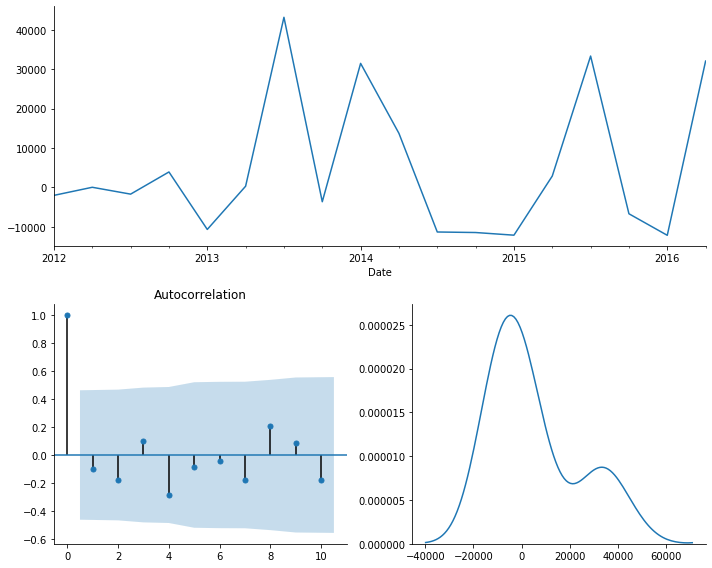

In [23]:
residcheck(model1.resid, 10);

In [150]:
sm.stats.diagnostic.kstest_normal(model1.resid,"norm")[1]

0.005477051755401487

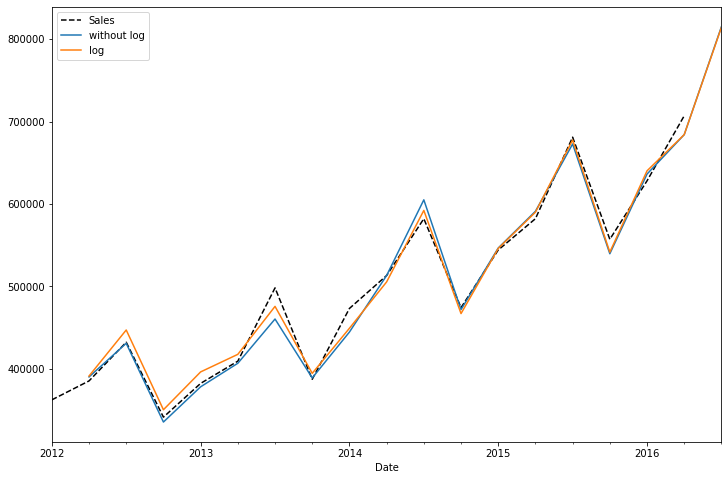

In [28]:
train.plot(legend=True, label="Sales Data", figsize=(12,8), cmap='gray', style='--')
model2.predict(1, len(train)).plot(legend=True, label="without log")
model6.predict(1, len(train)).plot(legend=True, label="log")


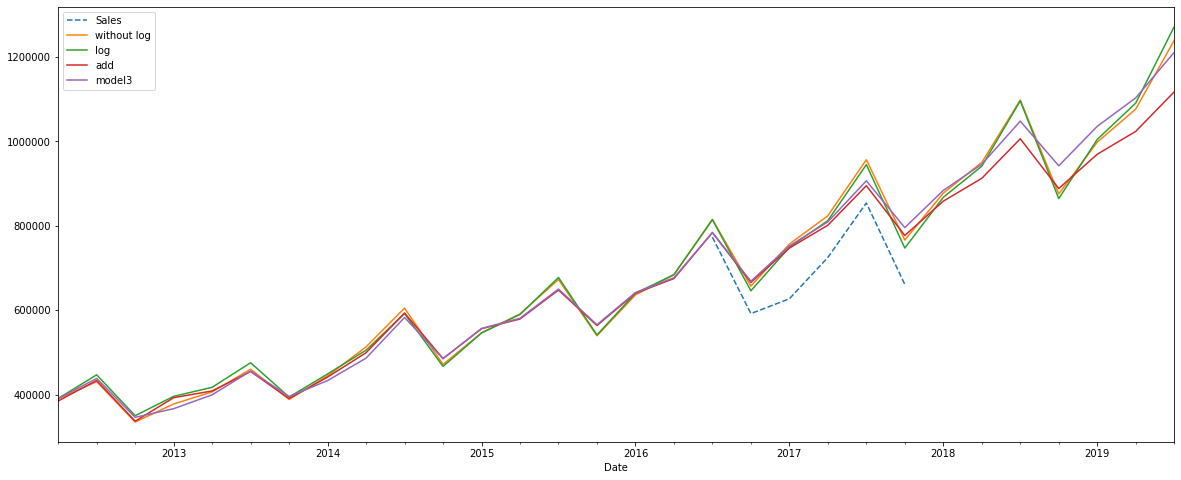

In [29]:
#data.plot(legend=True, label="Sales Data", figsize=(20,8), cmap='gray', style='--')
test.plot(legend=True, label="Test", figsize=(20,8), style='--')

model2.predict(1, len(data)+6).plot(legend=True, label="without log")
model6.predict(1, len(data)+6).plot(legend=True, label="log")
model1.predict(1, len(data)+6).plot(legend=True, label="add")
model3.predict(1, len(data)+6).plot(legend=True, label="model3")

In [5]:
%%R -i train -o ets_summary

library(fpp2)

r_train <- ts(train$Sales, start=c(2012,03,31), frequency=4)

ets_summary <- r_train %>% ets()



In [236]:
#Using tsCV

In [6]:
%%R -i data -o mean_e,mean_e2,mean_e3,mean_e_arima,mean_e_arima_box,lam

r_data <- ts(data$Sales, start=c(2012,03,31), frequency=4)

lam <- BoxCox.lambda(r_data)

fets1 <- function(x, h) {
  forecast(ets(x), h = h)
}

e <- tsCV(r_data, fets, h=1)
mean_e=mean(e^2, na.rm=TRUE)

#with log
fets2 <- function(x, h) {
  forecast(ets(x, lambda=0), h = h)
}

e_log <- tsCV(r_data, fets2, h=1)
mean_e2=mean(e_log^2, na.rm=TRUE)


#with BoxCox
fets3 <- function(x, h) {
  forecast(ets(x, lambda=lam), h = h)
}

e_box <- tsCV(r_data, fets3, h=1)
mean_e3=mean(e_box^2, na.rm=TRUE)


#with ARIMA
farima <- function(x, h) {
  forecast(auto.arima(x), h = h)
}

e_arima <- tsCV(r_data, farima, h=1)
mean_e_arima=mean(e_arima^2, na.rm=TRUE)

#with ARIMA & BoxCox
farima_box <- function(x, h) {
  forecast(auto.arima(x, lambda=lam), h = h)
}

e_arima2 <- tsCV(r_data, farima_box, h=1)
mean_e_arima_box=mean(e_arima2^2, na.rm=TRUE)






In [23]:
%%R -i data -o mean_e_MAM,mean_e_AAA,mean_e2

r_data <- ts(data$Sales, start=c(2012,03,31), frequency=4)

lam <- BoxCox.lambda(r_data)

fets_MAM <- function(x, h) {
  forecast(ets(x, model='MAM'), h = h)
}

e_MAM <- tsCV(r_data, fets_MAM, h=1)
mean_e_MAM=mean(e_MAM^2, na.rm=TRUE)


fets_AAA <- function(x, h) {
  forecast(ets(x, model='AAA'), h = h)
}

e_AAA <- tsCV(r_data, fets_AAA, h=1)
mean_e_AAA=mean(e_AAA^2, na.rm=TRUE)

#with log
fets_MAM_log <- function(x, h) {
  forecast(ets(x,model='MAM', lambda=lam), h = h)
}

e_log <- tsCV(r_data, fets_MAM_log, h=1)
mean_e2=mean(e_log^2, na.rm=TRUE)








In [24]:
print(mean_e_MAM,mean_e_AAA,mean_e2, end="")

[1] 2413822041
 [1] 2736208289
 [1] NaN


In [255]:
%%R -i data -o ets_summary2

library(fpp2)

r_data <- ts(data$Sales, start=c(2012,03,31), frequency=4)

ets_summary2 <- r_data %>% ets()

In [259]:
print(ets_summary)

ETS(M,A,M) 



Call:

 ets(y = .) 



  Smoothing parameters:

    alpha = 0.8309 

    beta  = 0.0055 

    gamma = 1e-04 



  Initial states:

    l = 338029.7256 

    b = 17199.4484 

    s = 0.8732 1.1323 1.0171 0.9773



  sigma:  0.0411



     AIC     AICc      BIC 

415.7237 438.2237 423.7370 



In [258]:
model2.summary()

Dep. Variable:,endog,No. Observations:,18
Model:,ExponentialSmoothing,SSE,4121103402.828
Optimized:,True,AIC,362.482
Trend:,Additive,BIC,369.605
Seasonal:,Multiplicative,AICC,393.911
Seasonal Periods:,4,Date:,"Thu, 19 Mar 2020"
Box-Cox:,False,Time:,19:10:57
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5789474,alpha,True
smoothing_slope,0.5789474,beta,True


In [264]:
%%R 
install.packages('dplyr')

In [267]:
data.tail()

,Sales
Date,
2016-12-31,592000
2017-03-31,627000
2017-06-30,725000
2017-09-30,854000
2017-12-31,661000


In [268]:
data.head()

,Sales
Date,
2012-03-31,362000
2012-06-30,385000
2012-09-30,432000
2012-12-31,341000
2013-03-31,382000


In [277]:
%R install.packages("rlang")

In [33]:
source = data.reset_index()

alt.Chart(...)

In [38]:
source = data.reset_index()
rolling = source["Sales"].rolling(3).mean()

In [48]:
base = alt.Chart(source).encode(x='Date')
data = base.mark_line().encode(y="Sales")
roll = alt.Chart(rolling).encode(x='Date', y='Sales')



In [55]:
alt.Chart(source).transform_density(
    'Sales',
    as_=['Sales', 'density'],
    extent = [0,1200]
).mark_area().encode(
    x="Sales:Q",
    y='density:Q',
)

alt.Chart(...)